<h1><center>Final Project - Open Set Recognition</center></h1>

# Imports

In [ ]:
import numpy as np 
import torch
import torchvision
import copy

import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

from torch.utils.data import Dataset
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import models
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from tqdm import tqdm

# Device setting up

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print("Using device:", device)

Using device: cuda


# Data & Preprocessing

## Random seeds


In [ ]:
torch.manual_seed(0)
np.random.seed(0)

## Preparing MNIST Transformations

In [ ]:
transform = T.Compose([
    T.ToTensor(),
    T.Normalize((0.5,), (0.5,))
])

## Preparing MNIST Datasets

In [ ]:
# Number of Training images
N = 30000
batch_size = 128

# Datasets
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                      download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                     download=True, transform=transform)

## MNIST Train, Validation and Test splits

In [ ]:
# Train and Validation split
train_size = len(trainset)
train_idx = np.arange(train_size)
train_subset_idx = np.random.choice(train_idx, N)
train_subset_idx, val_subset_idx = train_test_split(train_subset_idx, 
                                                    test_size=0.2, 
                                                    random_state=0)

# Create samplers
train_sampler = SubsetRandomSampler(train_subset_idx)
validaiton_sampler = SubsetRandomSampler(val_subset_idx)

## Preparing a subset of CIFAR10 as OOD Dataset

### Custom Dataset for OOD Dataset

In [ ]:
class OOD_Test_Dataset(Dataset):
    def __init__(self, datasets):
        [self.MNIST_dataset, self.OOD_dataset] = datasets
        self.total_lengths = [len(ds) for ds in datasets]
        self.length = np.sum(self.total_lengths)

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        if idx < self.total_lengths[0]:
            image, label = self.MNIST_dataset[idx]
            return image, label

        elif idx < self.length:
            idx -= self.total_lengths[0]
            image, _ = self.OOD_dataset.__getitem__(idx)
            label = 10
            return image, label

        raise IndexError(f'{idx} index out of range {self.length}')

### Mean and Standard deviation for CIFAR10
https://towardsdatascience.com/how-to-calculate-the-mean-and-standard-deviation-normalizing-datasets-in-pytorch-704bd7d05f4c

In [ ]:
mean = [0.4914, 0.4822, 0.4465]
standard_deviation = [0.2471, 0.2435, 0.2616]

### Creating OOD Dataset

In [ ]:
unknown_transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean, standard_deviation),
    T.Resize(28),
    T.Grayscale(num_output_channels=1)
])

# Number of OOD images
n = 500

# Datasets
unknown_testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                               download=True, transform=unknown_transform)

# Choosing a subset of CIFAR10
unknown_test_size = len(unknown_testset)
unknown_test_idx = np.arange(unknown_test_size)
unknown_test_subset_idx = np.random.choice(unknown_test_idx, n)
unknown_test_subset = torch.utils.data.Subset(unknown_testset, unknown_test_subset_idx)

# Creating the OOD Dataset
OOD_dataset = OOD_Test_Dataset([testset, unknown_test_subset])
OOD_only_dataset = OOD_Test_Dataset([[], unknown_test_subset])

## Preparing MNIST and OOD Dataloaders

In [ ]:
# Training Loaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          sampler=train_sampler, num_workers=2)
validationloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               sampler=validaiton_sampler, num_workers=2)

# Full MNIST Training Loader for GAN training
GAN_trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=False, num_workers=2)

# MNIST Testing Loader
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=True, num_workers=2)

# OOD Testing Loader
OOD_testloader = torch.utils.data.DataLoader(OOD_dataset, batch_size=500,
                                             shuffle=True, num_workers=2)

# OOD only Testing Loader (For Debugging)
OOD_only_testloader = torch.utils.data.DataLoader(OOD_only_dataset, batch_size=500,
                                                  shuffle=True, num_workers=2)

## Datasets Info

In [ ]:
trainset_size = len(train_subset_idx)
validset_size = len(val_subset_idx)
GAN_trainset_size = 60000
testset_size = len(testset)
OOD_testset_size = len(testset) + len(unknown_test_subset_idx)


print('='*25)
print('Train dataset:', trainset_size)
print('Validation dataset:', validset_size)
print('GAN Train dataset:', GAN_trainset_size)
print('Test dataset:', testset_size)
print('OOD Test dataset:', OOD_testset_size)
print('='*25)

Train dataset: 24000
Validation dataset: 6000
GAN Train dataset: 60000
Test dataset: 10000
OOD Test dataset: 10500


# Models

## Baseline model class

### CNN

In [ ]:
class ConvNet(nn.Module):
    def __init__(self, use_dropout=False, use_dropout2d=False):
        super(ConvNet, self).__init__()

        # flags
        self.use_dropout = use_dropout
        self.use_dropout2d = use_dropout2d
        # kernel
        # Conv2d(in_channels, out_channels, kernel_size)
        self.conv1 = nn.Conv2d(1, 64, 5, padding='same')
        self.conv2 = nn.Conv2d(64, 32, 3, padding='same')
        if self.use_dropout2d:
            self.spatial_dropout = nn.Dropout2d(p=0.2)
        # FC layers - since we use global avg pooling,
        # input to the FC layer = #output_features of the second conv layer
        self.fc1 = nn.Linear(32, 256)
        if self.use_dropout:
            self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # adaptive_avg_pool2d with output_size=1 = simple global avg pooling
        x = self.conv2(x)
        if self.use_dropout2d:
            x = self.spatial_dropout(x)
        x = F.relu(x)
        x = F.adaptive_avg_pool2d(x, 1)
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = F.relu(self.fc1(x))
        if self.use_dropout:
            x = self.dropout(x)
        x = self.fc2(x)
        return x

## OSR model class

### GAN

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)    

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, nc=784, ndf=98):
        super(Discriminator, self).__init__()
        self.nc = nc
        self.ndf = ndf
        self.main = nn.Sequential(
            nn.Conv2d(self.nc, self.ndf*8, 1, 1, 0, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(self.ndf*8, self.ndf*4, 1, 1, 0, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(self.ndf*4, self.ndf*2, 1, 1, 0, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(self.ndf*2, self.ndf, 1, 1, 0, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(self.ndf, 1, 1, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
class Generator(nn.Module):
    def __init__(self, nz=100, ngf=98, nc=784):
        super(Generator, self).__init__()
        self.nz = nz
        self.ngf = ngf
        self.nc = nc
        
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            # Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')
            nn.Conv2d(self.nz, self.ngf * 8, 1, 1, 0, bias=False),
            nn.ReLU(True),
            # state size. (self.ngf*8) x 4 x 4
            nn.Conv2d(self.ngf * 8, self.ngf * 4, 1, 1, 0, bias=False),
            nn.ReLU(True),
            # state size. (self.ngf*4) x 8 x 8
            nn.Conv2d(self.ngf * 4, self.ngf * 2, 1, 1, 0, bias=False),
            nn.ReLU(True),
            # state size. (self.ngf*2) x 16 x 16
            nn.Conv2d(self.ngf * 2, self.ngf*4, 1, 1, 0, bias=False),
            nn.ReLU(True),
            # state size. (self.ngf) x 32 x 32
            nn.Conv2d(self.ngf*4, self.nc, 1, 1, 0, bias=True),
            # state size. (self.nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

### OSR model - OpenGAN with CNN

In [ ]:
class OSR_GAN_ConvNet(nn.Module):
    def __init__(self, CNN_model, discriminator_model):
        super(OSR_GAN_ConvNet, self).__init__()
        self.CNN_model = CNN_model
        self.discriminator_model = discriminator_model
        self.threshold = 0.5
        self.input_size = 784

    def _detect_anomaly(self, CNN_result, discriminator_results):
        softmax = nn.Softmax(dim=1)
        prob_results = softmax(CNN_result)
        comparison_result = []

        for i in range(CNN_result.shape[0]):
            if discriminator_results[i] < self.threshold:
                comparison_result.append([1.1])
            else:
                comparison_result.append([0.0])
        
        ood_prob = torch.tensor(comparison_result).to(device)
        return torch.cat((prob_results, ood_prob), 1)

    def forward(self, x):
        CNN_result = self.CNN_model(x)
        x = x.reshape(-1, self.input_size, 1, 1)
        discriminator_results = self.discriminator_model(x)
        return self._detect_anomaly(CNN_result, discriminator_results)

# Training

## CNN Training

In [ ]:
CNN_model = ConvNet(use_dropout=True).to(device)
num_epochs = 50
softmax = nn.Softmax(dim=1)
CNN_criterion = nn.CrossEntropyLoss()
CNN_optimizer = optim.Adam(CNN_model.parameters(), lr=0.01)

optimal_val_epoch = 0
optimal_val_accuracy = 0

x_axis = list(range(num_epochs))
CNN_graph_data = {}
CNN_graph_data["train"] = {}
CNN_graph_data["valid"] = {}
CNN_graph_data["train"]["loss"] = []
CNN_graph_data["valid"]["loss"] = []
CNN_graph_data["train"]["accuracy"] = []
CNN_graph_data["valid"]["accuracy"] = []

In [ ]:
def train_epoch(model, dataloader, criterion, optimizer):
    model.train()  # Set model to train mode
    running_loss = 0
    running_corrects = 0
    
    for i, data in enumerate(dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        # mode to device/cuda
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        logits = model(inputs)
        _, preds = torch.max(logits, 1)

        # Cross-entropy loss - input=logits
        loss = criterion(logits, labels)

        loss.backward()
        optimizer.step()

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / trainset_size
    epoch_accuracy = ((running_corrects.double() / trainset_size) * 100).item()
    
    return epoch_loss, epoch_accuracy

In [ ]:
def val_epoch(model, dataloader, criterion):
    model.eval()  # Set model to evaluate mode
    running_loss = 0
    running_corrects = 0

    with torch.no_grad():
        for i, data in enumerate(dataloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            # mode to device/cuda
            inputs, labels = inputs.to(device), labels.to(device)
            logits = model(inputs)
            _, preds = torch.max(logits, 1)
            
            # Cross-entropy loss
            loss = criterion(logits, labels)

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)   

    epoch_loss = running_loss / validset_size
    epoch_accuracy = ((running_corrects.double() / validset_size) * 100).item()

    return epoch_loss, epoch_accuracy

In [ ]:
for epoch in tqdm(range(num_epochs)):
    train_loss, train_accuracy = train_epoch(CNN_model, trainloader, CNN_criterion, CNN_optimizer)
    val_loss, val_accuracy = val_epoch(CNN_model, validationloader, CNN_criterion)

    CNN_graph_data["train"]["loss"].append(train_loss)
    CNN_graph_data["valid"]["loss"].append(val_loss)
    CNN_graph_data["train"]["accuracy"].append(train_accuracy)
    CNN_graph_data["valid"]["accuracy"].append(val_accuracy)

    if val_accuracy > optimal_val_accuracy:
        optimal_val_epoch = epoch
        optimal_val_accuracy = val_accuracy
        PATH = "./cnn_parameters.pth"
        torch.save(copy.deepcopy(CNN_model.state_dict()), PATH) 

100%|██████████| 50/50 [04:55<00:00,  5.92s/it]


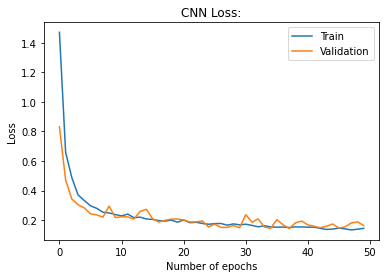

In [ ]:
plt.title("CNN Loss:")
plt.plot(x_axis, CNN_graph_data["train"]["loss"], label="Train")
plt.plot(x_axis, CNN_graph_data["valid"]["loss"], label="Validation")
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

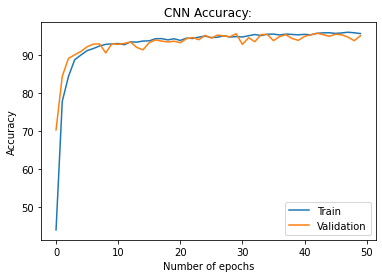

In [ ]:
plt.title("CNN Accuracy:")
plt.plot(x_axis, CNN_graph_data["train"]["accuracy"], label="Train")
plt.plot(x_axis, CNN_graph_data["valid"]["accuracy"], label="Validation")
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

## Loading the CNN with the best parameters found

In [ ]:
print("Optimal hyper parameters were found at:")
print("Epoch:", optimal_val_epoch)
print("The Validation Accuracy:", optimal_val_accuracy)

Optimal hyper parameters were found at:
Epoch: 42
The Validation Accuracy: 95.65


In [ ]:
PATH = "./cnn_parameters.pth"
CNN_model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

## OpenGAN Training

In [ ]:
# Number of channels in the training images. For color images this is 3
nc = 784

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in discriminator
ndf = 98

# Size of feature maps in generator
ngf = 98

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

lr = 0.0001 # learning rate

num_epochs = 50

torch.cuda.device_count()
torch.cuda.empty_cache()

In [ ]:
discriminator = Discriminator(nc=nc, ndf=ndf).to(device)
generator = Generator(nz=nz, ngf=ngf, nc=nc).to(device)

# Apply the weights_init function to randomly initialize all weights
# to mean=0, stdev=0.2.
discriminator.apply(weights_init)
generator.apply(weights_init)

# Initialize BCELoss function
criterion = nn.BCELoss()

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both D and G
optimizerD = optim.Adam(discriminator.parameters(), lr=lr/1.5, betas=(beta1, 0.999))
optimizerG = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
# Training Loop

# Lists to keep track of progress
G_losses = []
D_losses = []

print("Starting Training Loop...")
# For each epoch
for epoch in tqdm(range(num_epochs)):
    # For each batch in the dataloader
    for i, data in enumerate(GAN_trainloader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ############################
        ## Train with all-real batch
        discriminator.zero_grad()

        # Format batch
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        b_size = inputs.shape[0]

        # Converting the inputs to Vectors
        inputs = inputs.reshape(b_size, nc, 1, 1)
        label = torch.full((b_size, 1, 1, 1), real_label, dtype=torch.float, device=device)

        # Forward pass real batch through D
        output = discriminator(inputs)

        # Calculate loss on all-real batch
        errD_real = criterion(output, label)

        # Calculate gradients for D in backward pass
        errD_real.backward()


        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)

        # Generate fake image batch with G
        fake = generator(noise)
        label.fill_(fake_label)

        # Classify all fake batch with D
        output = discriminator(fake.detach())

        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)

        # Calculate the gradients for this batch
        errD_fake.backward()

        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake

        # Update D
        optimizerD.step()
        

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ############################
        generator.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost

        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = discriminator(fake)

        # Calculate G's loss based on this output
        errG = criterion(output, label)

        # Calculate gradients for G
        errG.backward()

        # Update G
        optimizerG.step()

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

Starting Training Loop...


100%|██████████| 50/50 [11:03<00:00, 13.27s/it]


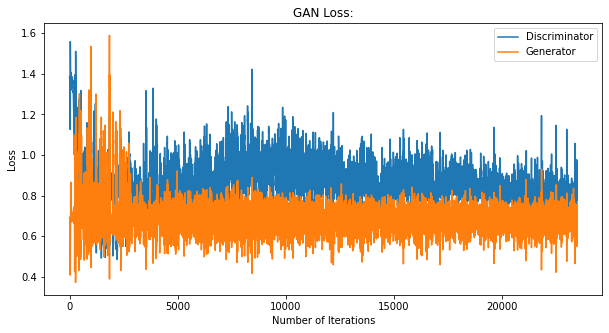

In [ ]:
plt.figure(figsize=(10, 5))
plt.title("GAN Loss:")
plt.plot(D_losses, label="Discriminator")
plt.plot(G_losses, label="Generator")
plt.xlabel("Number of Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

## The Trained Generator results

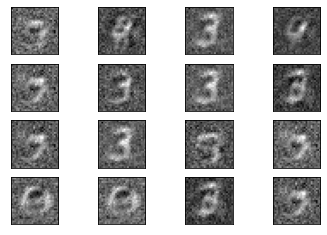

In [ ]:
latent_space_samples = torch.randn(batch_size, 100, 1, 1).to(device=device)
generated_samples = generator(latent_space_samples)

generated_samples = generated_samples.cpu().detach()
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(generated_samples[i].reshape(28, 28), cmap="gray")
    plt.xticks([])
    plt.yticks([])

In [45]:
latent_space_samples = torch.randn(batch_size, 100, 1, 1).to(device=device)
generated_samples = generator(latent_space_samples)
mean = 0
generated_samples = generated_samples.cpu().detach()
for i in range(batch_size):
    mean += discriminator(generated_samples[i].to(device)).item()
    
mean /= batch_size
print("The discriminator mean output on the generator samples:", mean)

The discriminator mean output on the generator samples: 0.4982670845929533


## Building the trained OSR model

In [ ]:
OSR_model = OSR_GAN_ConvNet(CNN_model, discriminator)

# Evaluation

## Basline results

### Testing on MNIST

In [ ]:
y_true = []
y_pred = []

In [ ]:
# computes accuracy on test set for numerical labels
def eval_baseline_model(model, dataloader):
    correct_count, all_count = 0, 0
    model.eval()
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            # logits
            outputs = model(inputs)
            preds_prob = softmax(outputs)
            _, preds = torch.max(preds_prob, 1)
            # eval labels here numeric (not one-hot)
            correct_pred = torch.eq(labels, preds).cpu()
            correct_count += correct_pred.numpy().sum()
            all_count += len(labels)

            y_true.extend(labels.tolist())
            y_pred.extend(preds.tolist())

    print("Number Of Images Tested =", all_count)
    print("Model Accuracy =", (correct_count/all_count)*100)

In [ ]:
eval_baseline_model(CNN_model, testloader)

Number Of Images Tested = 10000
Model Accuracy = 95.49


### Baseline results Confusion matrix

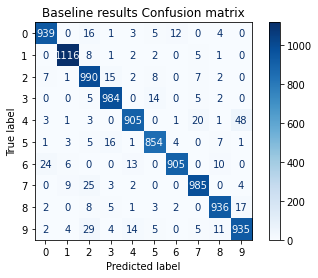

In [ ]:
clf_labels = [i for i in range(10)]
cm = confusion_matrix(y_true, y_pred, labels=clf_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf_labels)
disp.plot(cmap='Blues')
plt.title("Baseline results Confusion matrix")
plt.show()

## OOD results

### Testing on OOD

In [ ]:
y_true = []
y_pred = []

In [ ]:
def eval_OOD_model(model, dataloader):
    correct_count, all_count = 0, 0
    model.eval()
    with torch.no_grad():
      for inputs, labels in dataloader:
          inputs = inputs.to(device)
          labels = labels.to(device)
          # logits
          outputs = model(inputs)
          preds_prob = softmax(outputs)
          _, preds = torch.max(preds_prob, 1)

          # Binary transformation
          binary_labels = []
          binary_preds = []

          for i in range(inputs.shape[0]):
              binary_labels.append(0 if labels[i] < 10 else 1)
              binary_preds.append(0 if preds[i] < 10 else 1)
          
          binary_labels = torch.tensor(binary_labels).to(device)
          binary_preds = torch.tensor(binary_preds).to(device)
          
          # eval labels here numeric (not one-hot)
          correct_pred = torch.eq(binary_labels, binary_preds).cpu()
          correct_count += correct_pred.numpy().sum()
          all_count += len(labels)

          y_true.extend(binary_labels.tolist())
          y_pred.extend(binary_preds.tolist())

    print("Number Of Images Tested =", all_count)
    print("Model Accuracy =", (correct_count/all_count)*100)

In [ ]:
eval_OOD_model(OSR_model, OOD_testloader)

Number Of Images Tested = 10500
Model Accuracy = 97.28571428571429


### OOD results Confusion matrix

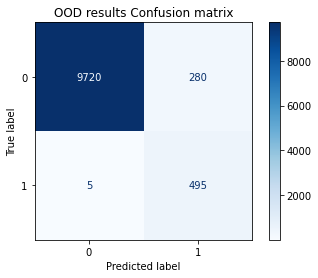

In [ ]:
clf_labels = [i for i in range(2)]
cm = confusion_matrix(y_true, y_pred, labels=clf_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf_labels)
disp.plot(cmap='Blues')
plt.title("OOD results Confusion matrix")
plt.show()

## OSR results

### Testing on OSR

In [ ]:
y_true = []
y_pred = []

In [ ]:
# computes accuracy on test set for numerical labels
def eval_OSR_model(model, dataloader):
    correct_count, all_count = 0, 0
    model.eval()
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            # logits
            outputs = model(inputs)
            preds_prob = softmax(outputs)
            _, preds = torch.max(preds_prob, 1)
            # eval labels here numeric (not one-hot)
            correct_pred = torch.eq(labels, preds).cpu()
            correct_count += correct_pred.numpy().sum()
            all_count += len(labels)

            y_true.extend(labels.tolist())
            y_pred.extend(preds.tolist())

    print("Number Of Images Tested =", all_count)
    print("Model Accuracy =", (correct_count/all_count)*100)

In [ ]:
eval_OSR_model(OSR_model, OOD_testloader)

Number Of Images Tested = 10500
Model Accuracy = 93.4952380952381


### OSR results Confusion matrix

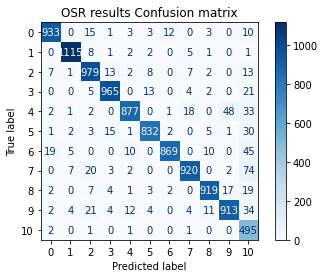

In [ ]:
clf_labels = [i for i in range(11)]
cm = confusion_matrix(y_true, y_pred, labels=clf_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf_labels)
disp.plot(cmap='Blues')
plt.title("OSR results Confusion matrix")
plt.show()

# Saving the model parameters

In [ ]:
PATH = "./cnn_parameters.pth"
torch.save(copy.deepcopy(CNN_model.state_dict()), PATH)

PATH = "./discriminator_parameters.pth"
torch.save(copy.deepcopy(discriminator.state_dict()), PATH)

PATH = "./generator_parameters.pth"
torch.save(copy.deepcopy(generator.state_dict()), PATH)

# Loading and Testing the saved model (Sanity Check)

## Required Imports

In [1]:
import numpy as np 
import torch
import torchvision
import copy

import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

from torch.utils.data import Dataset
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from tqdm import tqdm

## Setting up the Device

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print("Using device:", device)

Using device: cuda


## Model Neural Networks Classes

In [3]:
class ConvNet(nn.Module):
    def __init__(self, use_dropout=False, use_dropout2d=False):
        super(ConvNet, self).__init__()

        # flags
        self.use_dropout = use_dropout
        self.use_dropout2d = use_dropout2d
        # kernel
        # Conv2d(in_channels, out_channels, kernel_size)
        self.conv1 = nn.Conv2d(1, 64, 5, padding='same')
        self.conv2 = nn.Conv2d(64, 32, 3, padding='same')
        if self.use_dropout2d:
            self.spatial_dropout = nn.Dropout2d(p=0.2)
        # FC layers - since we use global avg pooling,
        # input to the FC layer = #output_features of the second conv layer
        self.fc1 = nn.Linear(32, 256)
        if self.use_dropout:
            self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # adaptive_avg_pool2d with output_size=1 = simple global avg pooling
        x = self.conv2(x)
        if self.use_dropout2d:
            x = self.spatial_dropout(x)
        x = F.relu(x)
        x = F.adaptive_avg_pool2d(x, 1)
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = F.relu(self.fc1(x))
        if self.use_dropout:
            x = self.dropout(x)
        x = self.fc2(x)
        return x

In [4]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)    

In [13]:
class Discriminator(nn.Module):
    def __init__(self, nc=784, ndf=98):
        super(Discriminator, self).__init__()
        self.nc = nc
        self.ndf = ndf
        self.main = nn.Sequential(
            nn.Conv2d(self.nc, self.ndf*8, 1, 1, 0, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(self.ndf*8, self.ndf*4, 1, 1, 0, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(self.ndf*4, self.ndf*2, 1, 1, 0, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(self.ndf*2, self.ndf, 1, 1, 0, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(self.ndf, 1, 1, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [14]:
class Generator(nn.Module):
    def __init__(self, nz=100, ngf=98, nc=784):
        super(Generator, self).__init__()
        self.nz = nz
        self.ngf = ngf
        self.nc = nc
        
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            # Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')
            nn.Conv2d(self.nz, self.ngf * 8, 1, 1, 0, bias=False),
            nn.ReLU(True),
            # state size. (self.ngf*8) x 4 x 4
            nn.Conv2d(self.ngf * 8, self.ngf * 4, 1, 1, 0, bias=False),
            nn.ReLU(True),
            # state size. (self.ngf*4) x 8 x 8
            nn.Conv2d(self.ngf * 4, self.ngf * 2, 1, 1, 0, bias=False),
            nn.ReLU(True),
            # state size. (self.ngf*2) x 16 x 16
            nn.Conv2d(self.ngf * 2, self.ngf*4, 1, 1, 0, bias=False),
            nn.ReLU(True),
            # state size. (self.ngf) x 32 x 32
            nn.Conv2d(self.ngf*4, self.nc, 1, 1, 0, bias=True),
            # state size. (self.nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [7]:
class OSR_GAN_ConvNet(nn.Module):
    def __init__(self, CNN_model, discriminator_model):
        super(OSR_GAN_ConvNet, self).__init__()
        self.CNN_model = CNN_model
        self.discriminator_model = discriminator_model
        self.threshold = 0.5
        self.input_size = 784

    def _detect_anomaly(self, CNN_result, discriminator_results):
        softmax = nn.Softmax(dim=1)
        prob_results = softmax(CNN_result)
        comparison_result = []

        for i in range(CNN_result.shape[0]):
            if discriminator_results[i] < self.threshold:
                comparison_result.append([1.1])
            else:
                comparison_result.append([0.0])
        
        ood_prob = torch.tensor(comparison_result).to(device)
        return torch.cat((prob_results, ood_prob), 1)

    def forward(self, x):
        CNN_result = self.CNN_model(x)
        x = x.reshape(-1, self.input_size, 1, 1)
        discriminator_results = self.discriminator_model(x)
        return self._detect_anomaly(CNN_result, discriminator_results)

## Loading the model paramerters from MyDrive

In [8]:
import os
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [9]:
BASE_PATH = 'gdrive/MyDrive/GMDL222_Final_Project/Final_Project_Model/'

In [63]:
CNN_model = ConvNet(use_dropout=True).to(device)
PATH = "cnn_parameters.pth"
CNN_model.load_state_dict(torch.load(os.path.join(BASE_PATH, PATH), map_location=torch.device(device)))

discriminator = Discriminator().to(device)
PATH = "discriminator_parameters.pth"
discriminator.load_state_dict(torch.load(os.path.join(BASE_PATH, PATH), map_location=torch.device(device)))

generator = Generator().to(device)
PATH = "generator_parameters.pth"
generator.load_state_dict(torch.load(PATH, map_location=torch.device(device)))

OSR_model = OSR_GAN_ConvNet(CNN_model, discriminator)

## Loading the model paramerters from Local Storage

In [62]:
CNN_model = ConvNet(use_dropout=True).to(device)
PATH = "./cnn_parameters.pth"
CNN_model.load_state_dict(torch.load(PATH, map_location=torch.device(device)))


discriminator = Discriminator().to(device)
PATH = "./discriminator_parameters.pth"
discriminator.load_state_dict(torch.load(PATH, map_location=torch.device(device)))

generator = Generator().to(device)
PATH = "./generator_parameters.pth"
generator.load_state_dict(torch.load(PATH, map_location=torch.device(device)))

OSR_model = OSR_GAN_ConvNet(CNN_model, discriminator)

## Creating the Test Dataloader

In [64]:
torch.manual_seed(0)
np.random.seed(0)

In [65]:
transform = T.Compose([
    T.ToTensor(),
    T.Normalize((0.5,), (0.5,))
])

In [66]:
batch_size = 128
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                     download=True, transform=transform)

In [67]:
class OOD_Test_Dataset(Dataset):
    def __init__(self, datasets):
        [self.MNIST_dataset, self.OOD_dataset] = datasets
        self.total_lengths = [len(ds) for ds in datasets]
        self.length = np.sum(self.total_lengths)

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        if idx < self.total_lengths[0]:
            image, label = self.MNIST_dataset[idx]
            return image, label

        elif idx < self.length:
            idx -= self.total_lengths[0]
            image, _ = self.OOD_dataset.__getitem__(idx)
            label = 10
            return image, label

        raise IndexError(f'{idx} index out of range {self.length}')

In [68]:
mean = [0.4914, 0.4822, 0.4465]
standard_deviation = [0.2471, 0.2435, 0.2616]

In [69]:
unknown_transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean, standard_deviation),
    T.Resize(28),
    T.Grayscale(num_output_channels=1)
])

# Number of OOD images
n = 500

# Datasets
unknown_testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                               download=True, transform=unknown_transform)

# Choosing a subset of CIFAR10
unknown_test_size = len(unknown_testset)
unknown_test_idx = np.arange(unknown_test_size)
unknown_test_subset_idx = np.random.choice(unknown_test_idx, n)
unknown_test_subset = torch.utils.data.Subset(unknown_testset, unknown_test_subset_idx)

# Creating the OOD Dataset
OOD_dataset = OOD_Test_Dataset([testset, unknown_test_subset])

Files already downloaded and verified


In [70]:
# OOD Testing Loader
OOD_testloader = torch.utils.data.DataLoader(OOD_dataset, batch_size=500,
                                             shuffle=True, num_workers=2)

## Checking that the model preformance stayed the same

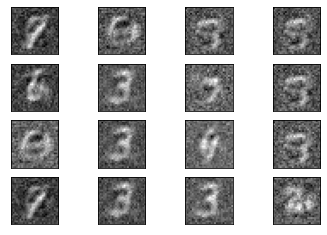

In [71]:
latent_space_samples = torch.randn(batch_size, 100, 1, 1).to(device=device)
generated_samples = generator(latent_space_samples)

generated_samples = generated_samples.cpu().detach()
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(generated_samples[i].reshape(28, 28), cmap="gray")
    plt.xticks([])
    plt.yticks([])

In [72]:
latent_space_samples = torch.randn(batch_size, 100, 1, 1).to(device=device)
generated_samples = generator(latent_space_samples)
mean = 0
generated_samples = generated_samples.cpu().detach()
for i in range(batch_size):
    mean += discriminator(generated_samples[i].to(device)).item()
    
mean /= batch_size
print("The discriminator mean output on the generator samples:", mean)

The discriminator mean output on the generator samples: 0.4965306904632598


In [73]:
softmax = nn.Softmax(dim=1)
y_true = []
y_pred = []

In [74]:
# computes accuracy on test set for numerical labels
def eval_OSR_model(model, dataloader):
    correct_count, all_count = 0, 0
    model.eval()
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            # logits
            outputs = model(inputs)
            preds_prob = softmax(outputs)
            _, preds = torch.max(preds_prob, 1)
            # eval labels here numeric (not one-hot)
            correct_pred = torch.eq(labels, preds).cpu()
            correct_count += correct_pred.numpy().sum()
            all_count += len(labels)

            y_true.extend(labels.tolist())
            y_pred.extend(preds.tolist())

    print("Number Of Images Tested =", all_count)
    print("Model Accuracy =", (correct_count/all_count)*100)

In [75]:
eval_OSR_model(OSR_model, OOD_testloader)

Number Of Images Tested = 10500
Model Accuracy = 93.5047619047619


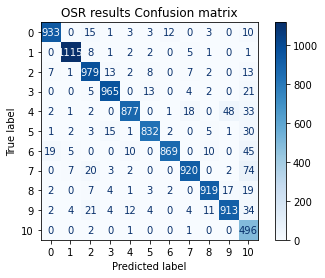

In [76]:
clf_labels = [i for i in range(11)]
cm = confusion_matrix(y_true, y_pred, labels=clf_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf_labels)
disp.plot(cmap='Blues')
plt.title("OSR results Confusion matrix")
plt.show()